# IMPORT LIBRARIES

In [1]:
import os
import cv2
import cv2 as cv

import numpy as np
from time import time
import zipfile, os
import pandas as pd

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
from google.colab import drive

from numpy import mean
from numpy import std
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm

from scipy.optimize import differential_evolution
from scipy.stats import norm


np.set_printoptions(suppress=True)

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#GET LABELS

In [3]:
def getLabels(path):
  labels = []
  for folder in os.listdir(directory):
    labels.append(folder)
  return labels

In [4]:
directory = "drive/MyDrive/dataset/covid19" #diganti dengan nama folder utama extrak dataset
labels = getLabels(directory)
labels

['Pneumonia', 'Normal', 'COVID19']

In [5]:
str = ""
for a in labels:
  str += a + ", "

print(str)


Pneumonia, Normal, COVID19, 


#CHECKING QUANTITY OF DATAS

In [6]:
# checking the size of data available to us for training out model
n_each_label = []
def checkingQuantityDatas(path):
  for label in labels:
    new_directory = os.path.join(directory, label)
    n_label = len(os.listdir(new_directory))
    n_each_label.append(n_label)
    print("n of label \"" + label + "\":\t", n_label)

In [7]:
start_load_data = time()
checkingQuantityDatas(directory)

print('\nLama Load Data: {:0.2f}'.format((time() - start_load_data)) + " Detik")

n of label "Pneumonia":	 882
n of label "Normal":	 441
n of label "COVID19":	 441

Lama Load Data: 0.06 Detik


In [8]:
classes_with_n = {}

for i in range(len(labels)):
    classes_with_n[labels[i]] = n_each_label[i]

#LABELIZATION

In [9]:
classes = {}

for i in range(len(labels)):
    classes[labels[i]] = i

img_height = 224
img_width = 224

classes

{'Pneumonia': 0, 'Normal': 1, 'COVID19': 2}

#PLOATING IMAGE

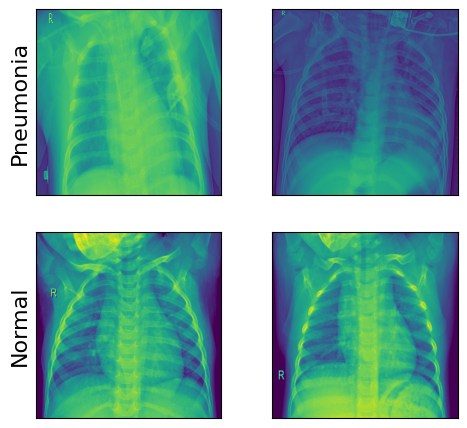

In [10]:
import matplotlib.image as mpimg

plt.figure(figsize=(30,14))

for i in range(2): #3
    new_directory = os.path.join(directory, labels[i])
    for j in range(2): #3
        path = os.path.join(new_directory, os.listdir(new_directory)[j])
        img = mpimg.imread(path)

        plt.subplot(5, 10, i*10 + j + 2)
        plt.imshow(img)

        if j == 0:
            plt.ylabel(labels[i], fontsize=16)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

# PREPROCESSING GAMBAR

Membagi Data

In [11]:
def load_data(dir):
    images = []
    labels = []
    size = img_height,img_width
    index = -1
    for folder in os.listdir(dir):
        index +=1
        index_data = -1
        for image in os.listdir(dir + "/" + folder):
            temp_img = cv2.imread(dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(classes[folder])
            index_data +=1

    images = np.array(images)
    images = images.astype('float32')/255.0
    labels = utils.to_categorical(labels)
    # x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, shuffle=True, random_state=1, stratify=labels)

    x, x_test, y, y_test = train_test_split(images, labels, test_size=0.2,train_size=0.8, shuffle=True, random_state=1)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25, shuffle=True, random_state=1)

    print('Num of Data = ', len(images))
    print("\n")
    print('Loaded', len(x_train),'images for training,','Train data shape =', x_train.shape)
    print('Loaded', len(x_val),'images for validating,','Validating data shape =', x_val.shape)
    print('Loaded', len(x_test),'images for test,','Testing data shape =', x_test.shape)
    print("\n")

    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
# Memanggil Fungsi load_data

start = time()
x_train, x_val, x_test, y_train, y_val, y_test = load_data(directory)

print('Lama Load Data: {:02.0f}'.format((time() - start)) + " Detik")

Num of Data =  1764


Loaded 1058 images for training, Train data shape = (1058, 224, 224, 3)
Loaded 353 images for validating, Validating data shape = (353, 224, 224, 3)
Loaded 353 images for test, Testing data shape = (353, 224, 224, 3)


Lama Load Data: 74 Detik


#ARCHITECTURE MODEL CNN MOBILE NET

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a ChannelSpatialAttention layer
class ChannelSpatialAttention(layers.Layer):
    def __init__(self, reduction=16, **kwargs):
        super(ChannelSpatialAttention, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        channels = input_shape[-1]
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = layers.Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        self.convolution = layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        super(ChannelSpatialAttention, self).build(input_shape)

    def call(self, x):
        # Channel Attention
        channel_avg = self.avg_pool(x)
        channel_attention = self.dense2(self.dense1(channel_avg))
        channel_attention = layers.Reshape((1, 1, -1))(channel_attention)

        # Spatial Attention
        spatial_avg = tf.reduce_mean(x, axis=-1, keepdims=True)
        spatial_attention = self.convolution(spatial_avg)

        # Combine Channel and Spatial Attention
        attention = channel_attention * spatial_attention

        return x * attention

# Build the model with ChannelSpatialAttention
model = models.Sequential([
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    ChannelSpatialAttention(),  # Add ChannelSpatialAttention here
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    ChannelSpatialAttention(),  # Add ChannelSpatialAttention here
    layers.Flatten()
])

model.add(layers.Dense(3, activation='softmax'))

#CREATE MODEL CNN

In [14]:
model.compile(optimizer=tf.optimizers.Adam() ,loss = tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 28)      784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 28)      0         
 D)                                                              
                                                                 
 channel_spatial_attention   (None, 111, 111, 28)      57        
 (ChannelSpatialAttention)                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      16192     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                        

#TRAINING MODEL

In [16]:
start_train_time = time()
epochs = 20
history = model.fit(x_train, y_train, validation_data = (x_val, y_val),  epochs = epochs)

Epoch 1/20
34/34 [==============================] - 8s 99ms/step - loss: 0.8168 - accuracy: 0.6503 - val_loss: 0.4506 - val_accuracy: 0.8215
Epoch 2/20
34/34 [==============================] - 2s 62ms/step - loss: 0.4126 - accuracy: 0.8459 - val_loss: 0.4072 - val_accuracy: 0.8017
Epoch 3/20
34/34 [==============================] - 2s 60ms/step - loss: 0.3403 - accuracy: 0.8866 - val_loss: 0.2975 - val_accuracy: 0.8952
Epoch 4/20
34/34 [==============================] - 2s 54ms/step - loss: 0.2281 - accuracy: 0.9187 - val_loss: 0.2098 - val_accuracy: 0.9263
Epoch 5/20
34/34 [==============================] - 2s 55ms/step - loss: 0.1695 - accuracy: 0.9367 - val_loss: 0.2787 - val_accuracy: 0.8867
Epoch 6/20
34/34 [==============================] - 2s 57ms/step - loss: 0.1863 - accuracy: 0.9338 - val_loss: 0.2081 - val_accuracy: 0.9348
Epoch 7/20
34/34 [==============================] - 2s 57ms/step - loss: 0.1260 - accuracy: 0.9565 - val_loss: 0.2013 - val_accuracy: 0.9292
Epoch 8/20
34

#PLOTING HISTORY MODEL FUNCTION & TESTING

In [17]:
def plot(model, history, train_time, x_test, y_test):
  # Visualisasi Akurasi training(latih) & validasi pada setiap model
  plt.figure(figsize=(12, 12))

  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()

  # Visualisasi kesalahan training(latih) & validasi pada setiap model
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('lose')
  plt.legend()

  plt.show()

  start_test = time()
  test_loss, test_acc = model.evaluate(x_test, y_test)
  test_time = time() - start_test

  print('Train accuracy: {:5.2f}%'.format(100 * (history.history['accuracy'][epochs-1])))
  print('Train loss: {:5.2f}% \n'.format(100 * (history.history['loss'][epochs-1])))

  print('Test accuracy: {:5.2f}%'.format(100 * test_acc))
  print('Test loss: {:5.2f}% \n'.format(100 * test_loss))

  print('Waktu Trainig: {:02.0f} '. format(train_time) + " Second")
  print('Waktu Testing: {:02.0f}'. format(test_time) + " Second")

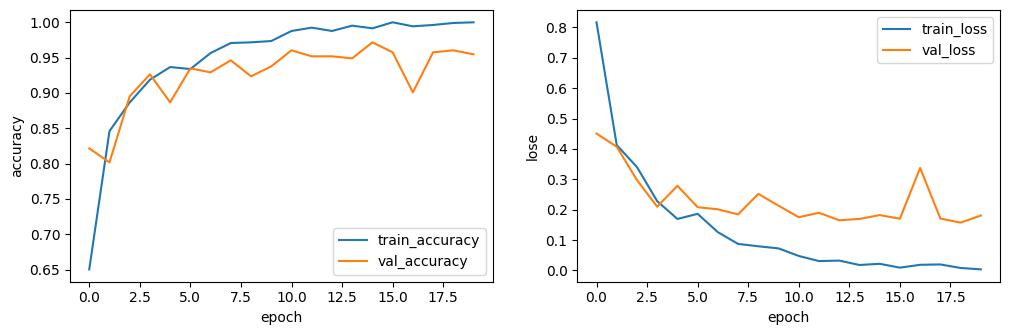

12/12 [==============================] - 0s 25ms/step - loss: 0.1221 - accuracy: 0.9462
Train accuracy: 100.00%
Train loss:  0.35% 

Test accuracy: 94.62%
Test loss: 12.21% 

Waktu Trainig: 85  Second
Waktu Testing: 01 Second


In [18]:
plot(model, history, time() - start_train_time, x_test, y_test)

In [19]:
label_kebenaran = argmax(y_test, axis=1)
label_testing = argmax(model.predict(x_test), axis=1)

12/12 [==============================] - 0s 18ms/step


In [20]:
print("\nAccuracy Score = {:5.2f}%".format(100 * accuracy_score(label_kebenaran, label_testing)))


Accuracy Score = 94.62%


# FUNGSI PEMBANTU PLOTING CONFUSION MATRIK

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools


uniq_labels = labels
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (12, 14))
    ax = plt.subplot()
    plt.imshow(cm, cmap = plt.cm.Purples)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=90)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(12)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

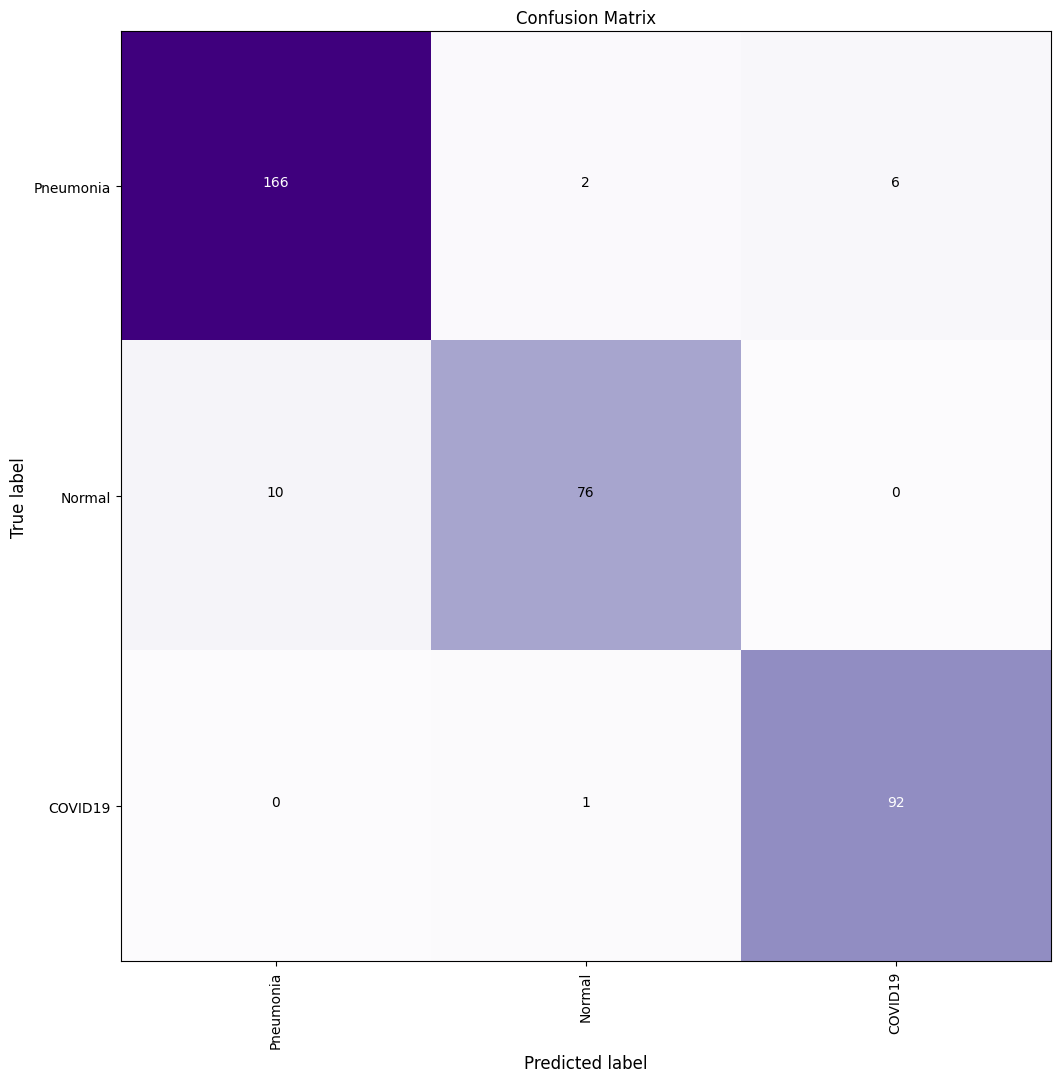

In [22]:
plot_confusion_matrix(label_kebenaran, label_testing)

In [23]:
print(classification_report(label_kebenaran, label_testing))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       174
           1       0.96      0.88      0.92        86
           2       0.94      0.99      0.96        93

    accuracy                           0.95       353
   macro avg       0.95      0.94      0.94       353
weighted avg       0.95      0.95      0.95       353



# FUNGSI PEMBANTU UPLOAD, DECODING, DAN PREDIKSI GAMBAR PER MODEL

In [24]:
from google.colab import files

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def upload_gambar():
  uploaded = files.upload()

  for fn in uploaded.keys():
    # predicting images
    img = tf.io.read_file(fn)
    img = decode_img(img)/255.0
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    return img

def prediksi_per_model(upload_gambar):
  x = upload_gambar
  start = time()

  y_pred =  myModel.predict(x)
  score = tf.nn.softmax(y_pred)
  result_pred = labels[argmax(y_pred)]
  print("Hasil Prediksi member ke: {0}".format(result_pred))
  print(y_pred)
  print('Lama Prediksi: {:0f}'.format(time() - start) + " Detik")

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(result_pred, 100 * np.max(y_pred[0][argmax(y_pred)]))
      )
  print("-------------------------------------- \n")

In [ ]:
prediksi_per_model(upload_gambar())